# Speech analysis and re-synthesis

This notebook demonstrates how to analyze speech and re-synthesis speech waveform from speech parameters using [pysptk](https://github.com/r9y9/pysptk) (and other useful speech/audio/music analysis packages). Synthesized audio examples are provided so that you are able to compare synthesis filters on your browser.

## Requirements

- pysptk: https://github.com/r9y9/pysptk
- scipy
- librosa: https://github.com/bmcfee/librosa
- seaborn: https://github.com/mwaskom/seaborn

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
import seaborn
seaborn.set(style="dark")
rcParams['figure.figsize'] = (16, 5)

In [3]:
from IPython.display import Audio

In [4]:
import numpy as np
import librosa
import pysptk
import pysas
from scipy.io import wavfile

## Data

In [5]:
sr, x = wavfile.read(pysptk.util.example_audio_file())
assert sr == 16000
print(x.shape)

(64000,)


/Users/ryuyamamoto/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


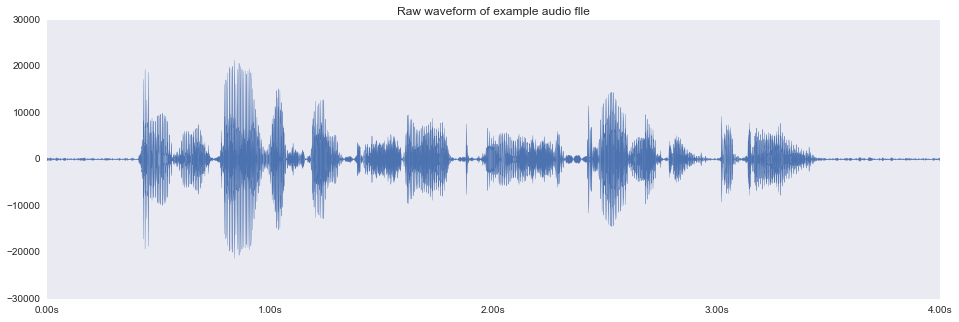

In [6]:
librosa.display.waveplot(x, sr=sr)
title("Raw waveform of example audio flle")
Audio(x, rate=sr)

## Source parameter extraction

### Framing and windowing

In [7]:
frame_length = 1024
hop_length = 80

# Note that almost all of pysptk functions assume input array is C-contiguous and np.float4 element type
frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T

# Windowing
frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length 

### F0 estimation

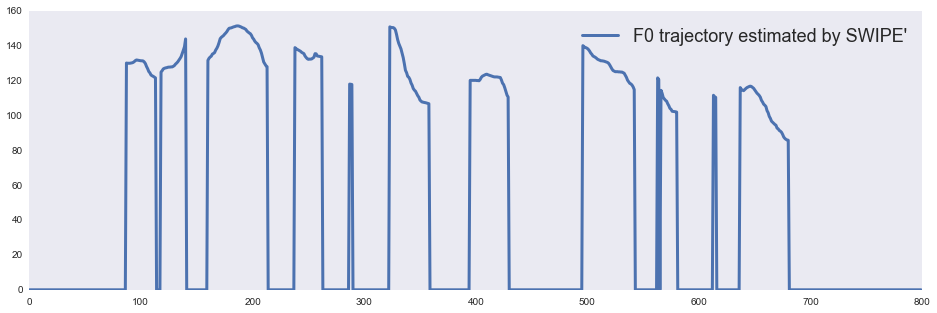

In [8]:
# F0 estimation
f0 = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="f0")
plot(f0, linewidth=3, label="F0 trajectory estimated by SWIPE'")
xlim(0, len(f0))
legend(prop={'size': 18})

## Source excitation generation

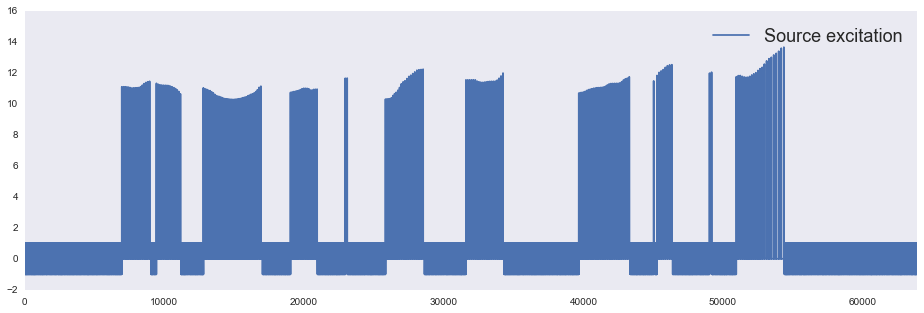

In [9]:
# Note that pysptk.excite assuems input as pitch, not *f0*.
pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="pitch")
source_excitation = pysptk.excite(pitch, hop_length)
                            
plot(source_excitation, label="Source excitation")
xlim(0, len(source_excitation))
ylim(-2, 16)
legend(prop={'size': 18})

## Synthesis from mel-cepstrum

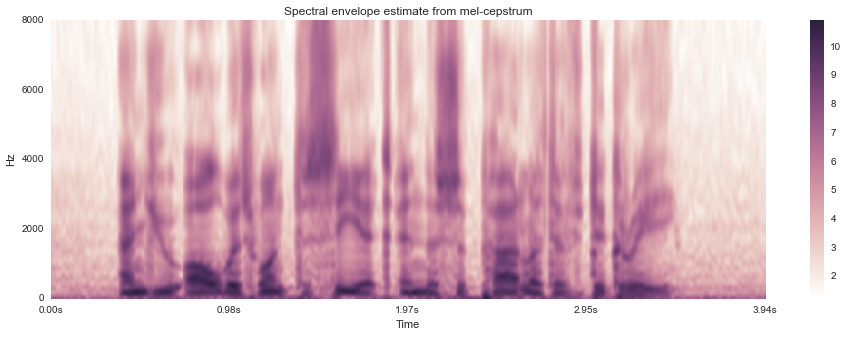

In [10]:
# Order of mel-cepstrum
order = 25
alpha = 0.41

# apply function along with `time` axis (=1)
mc = np.apply_along_axis(pysptk.mcep, 1, frames, order, alpha) # numpy >= v0.19.0 also supports keyword arguments like alpha=0.41 as well

logH = np.apply_along_axis(pysptk.mgc2sp, 1, mc, alpha, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-cepstrum")

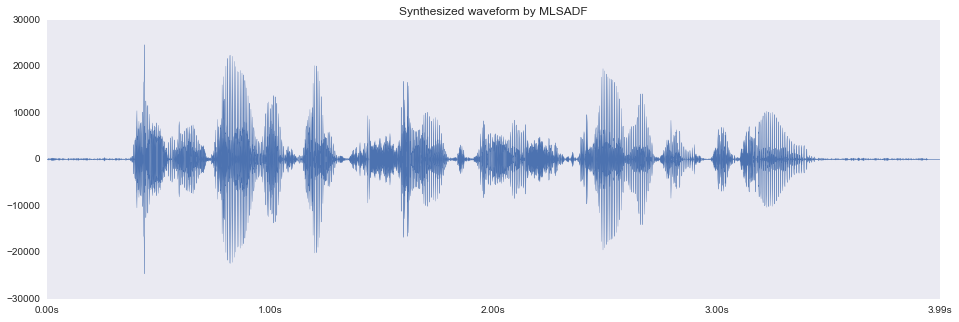

In [11]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cesptrum to MLSADF coefficients
b = np.apply_along_axis(pysptk.mc2b, 1, mc, alpha);

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=sr)
title("Synthesized waveform by MLSADF")
Audio(x_synthesized, rate=sr)

## Synthesis from cepstrum

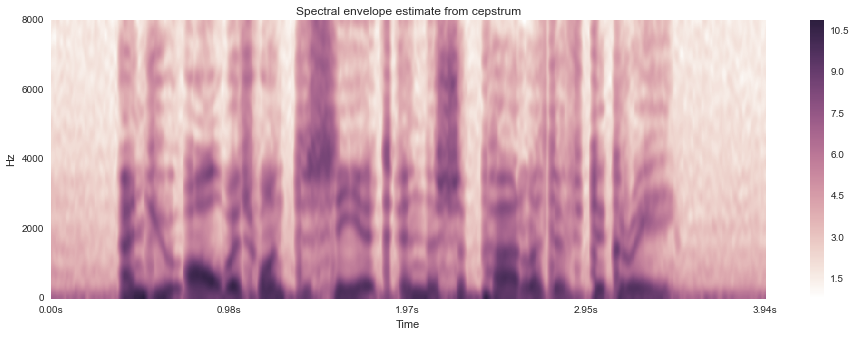

In [12]:
# Order of mel-cepstrum
order = 25

# apply function along with `time` axis (=1)
c = np.apply_along_axis(pysptk.mcep, 1, frames, order, 0.0)

logH = np.apply_along_axis(pysptk.mgc2sp, 1, c, 0.0, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from cepstrum")

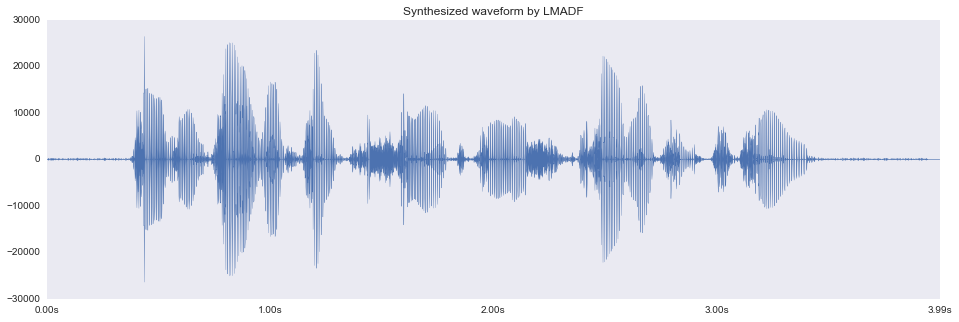

In [13]:
from pysptk.synthesis import LMADF

synthesizer = Synthesizer(LMADF(order=order), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, c)

librosa.display.waveplot(x_synthesized, sr=sr)
title("Synthesized waveform by LMADF")
Audio(x_synthesized, rate=sr)

## Synthesis from mel-generalized cepstrum

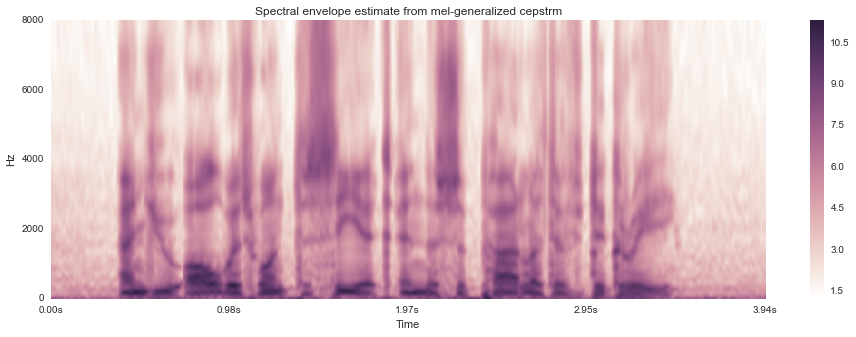

In [14]:
# Order of mel-cepstrum
order = 25
alpha = 0.41
stage = 5
gamma = -1.0 / stage

# apply function along with `time` axis (=1)
mgc = np.apply_along_axis(pysptk.mgcep, 1, frames, order, alpha, gamma)

logH = np.apply_along_axis(pysptk.mgc2sp, 1, mgc, alpha, gamma, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrm")

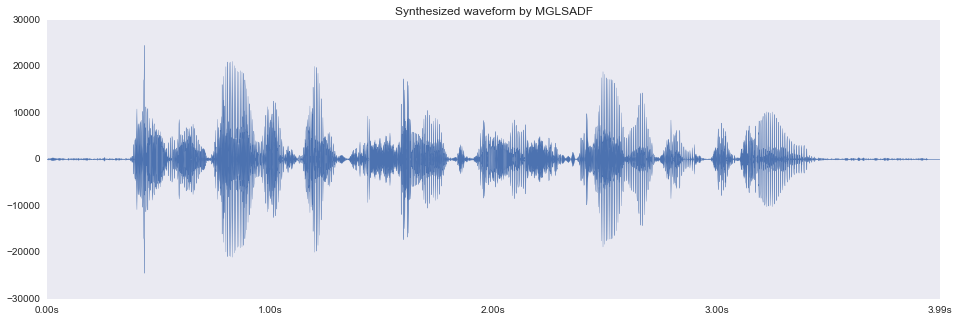

In [15]:
from pysptk.synthesis import MGLSADF

# Convert mel-generalized cesptrum to MGLSADF coefficients
b = np.apply_along_axis(pysptk.mgc2b, 1, mgc, alpha, gamma);

synthesizer = Synthesizer(MGLSADF(order=order, alpha=alpha, stage=stage), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=sr)
title("Synthesized waveform by MGLSADF")
Audio(x_synthesized, rate=sr)

## Synthesis from LPC

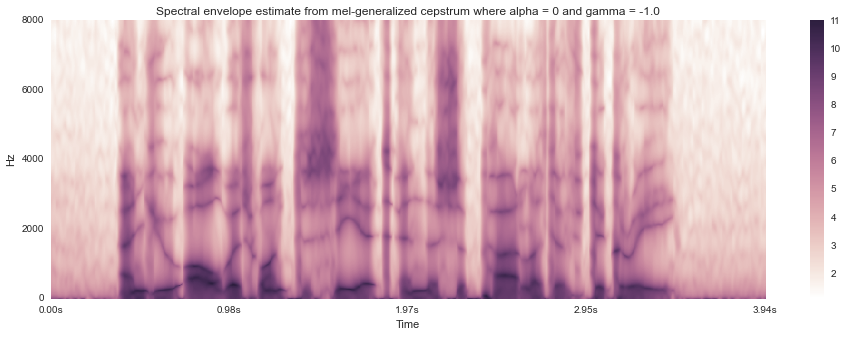

In [16]:
# Order of mel-cepstrum
order = 25

# apply function along with `time` axis (=1)
mgc = np.apply_along_axis(pysptk.mgcep, 1, frames, order, 0.0, -1.0)

logH = np.apply_along_axis(pysptk.mgc2sp, 1, mgc, 0.0, -1.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrum where alpha = 0 and gamma = -1.0")

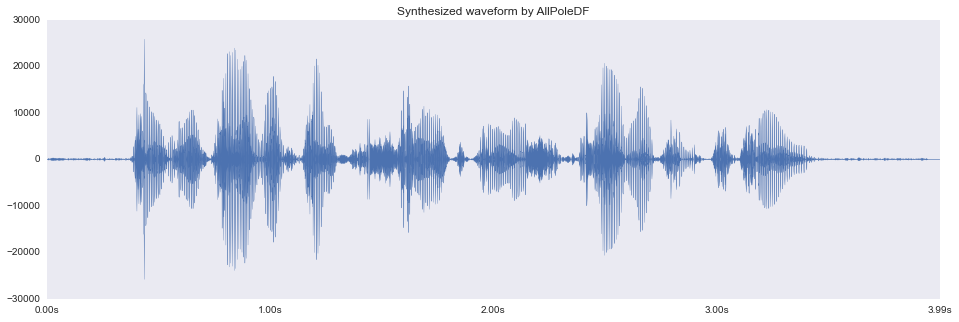

In [17]:
from pysptk.synthesis import AllPoleDF

lpc = np.apply_along_axis(pysptk.lpc, 1, frames, order)

# make sure lpc has loggain
lpc[:, 0] = np.log(lpc[:, 0])

synthesizer = Synthesizer(AllPoleDF(order=order), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, lpc)

librosa.display.waveplot(x_synthesized, sr=sr)
title("Synthesized waveform by AllPoleDF")
Audio(x_synthesized, rate=sr)

For more synthesis filters, please refer the documentation: http://pysptk.readthedocs.org/